# Clustering and visualizing the `penguins` dataset in 2D with *Self-Organizing Map*

In [01_kmeans_clustering.ipynb](./01_kmeans_clustering.ipynb) we use/used the `K-Means` algorithm to find groups of data points. In [02_som_representation_learning.ipynb](./02_som_representation_learning.ipynb) we use *Self-Organizing Map* to learn the representation of the dataset.

Here we want to find the optimal SOM hyperparameter combination that fits the data closely while the map still remaining organized.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAND = 42

## Dataset

In [10]:
X_scaled = pd.read_csv("../datasets/penguins/simple/X_scaled.csv", index_col=0, header=0)
X_scaled_idx = X_scaled.index
X_scaled = X_scaled.to_numpy()
y = pd.read_csv("../datasets/penguins/simple/y.csv", index_col=0, header=0)

## Representation learning

In [11]:
from _utilities.som import calc_recommended_grid_size, train_som

In [12]:
print("Recommended grid size:", calc_recommended_grid_size(X_scaled))

Recommended grid size: (np.float64(92.46621004453465), 10)


In [13]:
best_pos = [13, 39, 0.6]

In [14]:
# hyperparameter optimization

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import pyswarms as ps

def single_trial(p):
	SOM_DIM = int(p[0])
	SOM_SIGMA = np.round(SOM_DIM / 3, 2)
	SOM_NUM_ITERATION = int(p[1])
	SOM_LEARNING_RATE = np.round(p[2], 1)

	hyparams = {
		"d1": SOM_DIM,
		"d2": SOM_DIM,
		"sigma": SOM_SIGMA,
		"learning_rate": SOM_LEARNING_RATE,
		"num_iteration": SOM_NUM_ITERATION,
		"topology": "rectangular"
	}

	som = train_som(X=X_scaled, **hyparams, random_seed=RAND, verb=False)

	node_weights = som.get_weights()
	node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])

	clustering = AgglomerativeClustering(n_clusters=3, linkage="ward")
	clustering.fit(node_weights_flat)

	score = silhouette_score(node_weights_flat, clustering.labels_, metric="euclidean")

	return score * -1

def objective(params):
    return np.array([single_trial(p) for p in params])

bounds = (np.array([10, 20, 0.5]),  # min d, min epochs, min lr
          np.array([14, 100, 0.8]))  # max d, max epochs, max lr

options = {'c1': 1.25, 'c2': 1.25, 'w': 0.75}
optimizer = ps.single.GlobalBestPSO(n_particles=25, dimensions=3, options=options, bounds=bounds)

if best_pos is None:
	best_cost, best_pos = optimizer.optimize(objective, iters=5)

	print("Optimal hyperparameters:", best_pos)
	print("Best score:", best_cost)

In [15]:
SOM_DIM = int(best_pos[0])
SOM_SIGMA = np.round(SOM_DIM / 3, 2)
SOM_NUM_ITERATION = int(best_pos[1])
SOM_LEARNING_RATE = np.round(best_pos[2], 1)

print("Final hyperparameters:", SOM_DIM, SOM_SIGMA, SOM_NUM_ITERATION, SOM_LEARNING_RATE)

hyparams = {
    "d1": SOM_DIM,
    "d2": SOM_DIM,
    "sigma": SOM_SIGMA,
    "learning_rate": SOM_LEARNING_RATE,
    "num_iteration": SOM_NUM_ITERATION,
    "topology": "rectangular"
}

som = train_som(X=X_scaled, **hyparams, random_seed=RAND, verb=True)

node_weights = som.get_weights()
node_weights_flat = node_weights.reshape(-1, node_weights.shape[2])
activation_map = som.activation_response(X_scaled)
activations_flat = activation_map.flatten()

assert som.topographic_error(X_scaled) < .1, "The SOM is not organized!"

Final hyperparameters: 13 4.33 39 0.6
 [ 13338 / 13338 ] 100% - 0:00:00 left 
 quantization error: 0.45068070394391485

Brief quality of SOM:
Quantization error:	0.451
Topographic error:	0.018
Topographic error (VN):	0.111


In [16]:
import pickle

EXPORT_SOM = True

if EXPORT_SOM:
	with open("models/som_optimized_model.p", "wb") as outfile:
		pickle.dump(som, outfile)
else: print("Export is turned off")

In [17]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_scaled)

X_scaled_pca = pca.transform(X_scaled)
node_weights_flat_pca = pca.transform(node_weights_flat)

explained_var = np.round(pca.explained_variance_ratio_.sum(), 3)
print("PCA features explained variance:", explained_var)

PCA features explained variance: 0.973


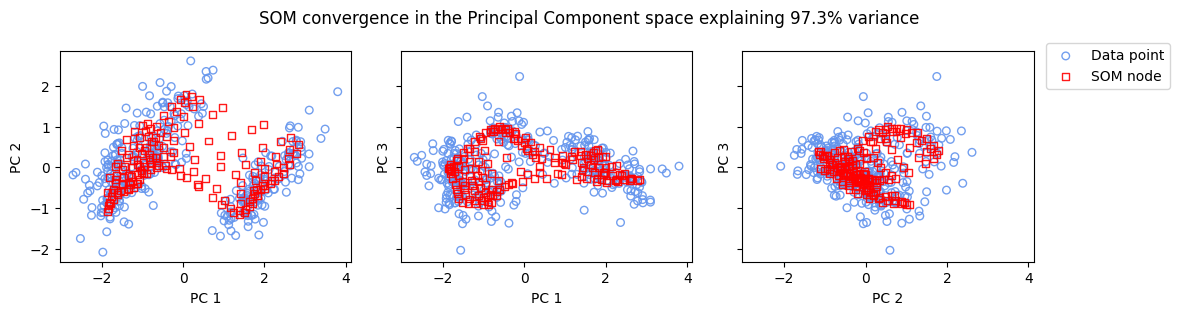

In [18]:
from _utilities.som_plot import plot_three_variables_pairwise

title = f"SOM convergence in the Principal Component space explaining {explained_var*100}% variance"
plot_three_variables_pairwise(layers=[
		{
			"data": X_scaled_pca,
			"label": "Data point",
		},
		{
			"data": node_weights_flat_pca,
			"label": "SOM node",
			"styles": {"edgecolor": "red", "marker": "s", "s": 25}
		}
	], axis_label="PC", figsize=(12, 3), title=title)

In [19]:
from _utilities.som_plot import plot_in_3PC

plot_in_3PC(layers=[{
	"data": X_scaled_pca,
	"label": "Data point",
	"nodeWeights": node_weights_flat_pca,
	"gridShape": node_weights.shape,
	"marker": dict(size=4, opacity=.9, color="cornflowerblue")
	}])

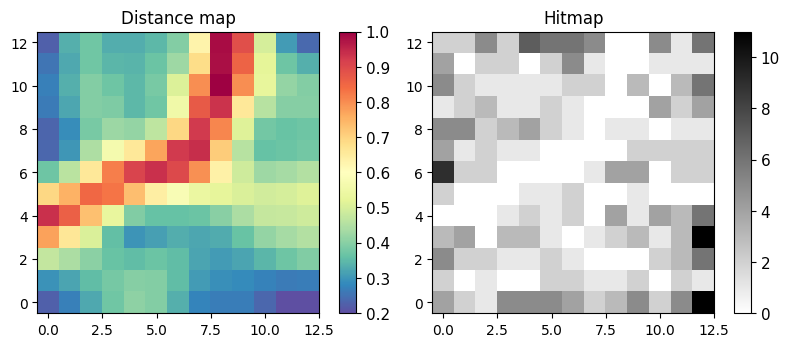

In [20]:
from _utilities.som_plot import visualize_distance_map, visualize_hitmap

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

visualize_distance_map(som=som, X=X_scaled, ax=ax0)
visualize_hitmap(som=som, X=X_scaled, ax=ax1)

plt.tight_layout()         
plt.show()

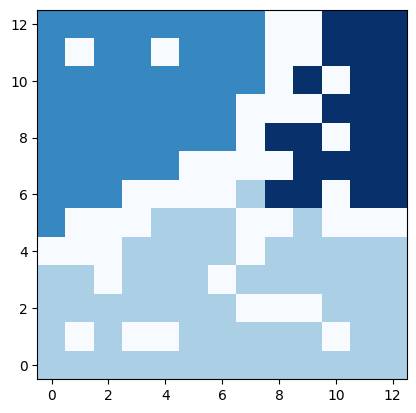

In [21]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, linkage="ward")
clustering.fit(node_weights_flat)

clustering_map = clustering.labels_.reshape(activation_map.shape)
clustering_map[activation_map == 0] = -1

plt.imshow(clustering_map, origin="lower", cmap="Blues")
plt.show()

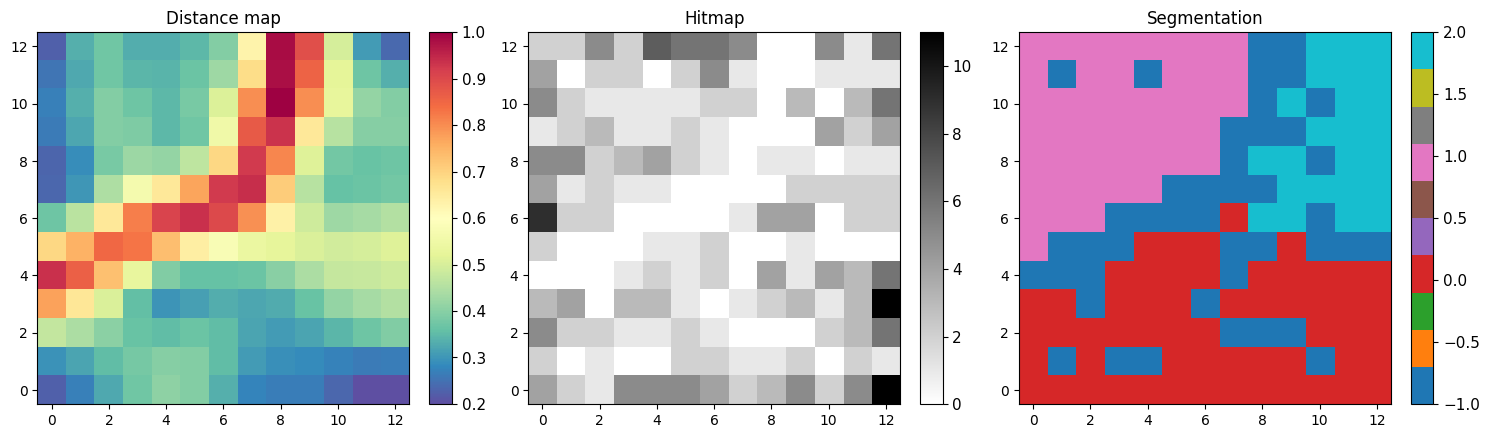

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 5))

visualize_distance_map(som=som, X=X_scaled, ax=ax0)
visualize_hitmap(som=som, X=X_scaled, ax=ax1)

ax2.set_title("Segmentation")
seg = ax2.imshow(clustering_map, origin="lower", cmap="tab10")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="6%", pad=0.2)
cax.tick_params(labelsize=11)
cbar = plt.colorbar(seg, cax=cax)

plt.tight_layout()
plt.show()

In [23]:
# make clustering predictions and export

y_pred = np.array([clustering_map[som.winner(x)] for x in X_scaled])

df_pred = pd.DataFrame(y_pred, index=X_scaled_idx, columns=['cluster_id'])
df_pred.to_csv("predictions/03_02_som_clustering_predictions.csv")